# "Spatial Clustering" - the Galaxy Correlation Function


* The degree to which objects positions are correlated with each other - "clustered" - is of great interest in astronomy. 


* We expect galaxies to appear in groups and clusters, as they fall together under gravity: the statistics of galaxy clustering should contain information about galaxy evolution during hierarchical structure formation.


* Let's try and measure a clustering signal in our SDSS photometric object catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from __future__ import print_function
import numpy as np
import SDSS
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import copy

In [22]:
# We want to select galaxies, and then are only interested in their positions on the sky.

data = pd.read_csv("downloads/SDSSobjects.csv",usecols=['ra','dec','u','g',\
                                                'r','i','size'])

# Filter out objects with bad magnitude or size measurements:
data = data[(data['u'] > 0) & (data['g'] > 0) & (data['r'] > 0) & (data['i'] > 0) & (data['size'] > 0)]

# Make size cuts, to exclude stars and nearby galaxies, and magnitude cuts, to get good galaxy detections:
data = data[(data['size'] > 0.8) & (data['size'] < 10.0) & (data['i'] > 17) & (data['i'] < 22)]

# Drop the things we're not so interested in:
del data['u'], data['g'], data['r'], data['i'],data['size']

data.head()

,ra,dec
1,185.103931,15.009721
3,185.029622,15.000569
5,185.069606,15.108364
8,185.104513,15.059163
21,185.142987,15.067263


In [24]:
Ngals = len(data)
ramin,ramax = np.min(data['ra']),np.max(data['ra'])
decmin,decmax = np.min(data['dec']),np.max(data['dec'])
print (Ngals,"galaxy-like objects in (ra,dec) range (",ramin,":",ramax,",",decmin,":",decmax,")")

987 galaxy-like objects in (ra,dec) range ( 185.000415714 : 185.199844645 , 15.000287913 : 15.1996295363 )


## The Correlation Function


* The 2-point correlation function $\xi(\theta)$ is defined as "the probability of finding two galaxies separated by an angular distance $\theta$ with respect to that expected for a random distribution" (Peebles 1980), and is an excellent summary statistic for quantifying the clustering of galaxies.


* The simplest possible _estimator_ for this excess probability is just 
$\hat{\xi}(\theta) = \frac{DD - RR}{RR}$, 
where $DD(\theta) = N_{\rm pairs}(\theta) / N_D(N_D-1)/2$. Here, $N_D$ is the total number of galaxies in the dataset, and $N_{\rm pairs}(\theta)$ is the number of galaxy pairs with separation lying in a bin centered on $\theta$. $RR(\theta)$ is the same quantity computed in a "random catalog," covering the same field of view but with uniformly randomly distributed positions.


* Correlations between mock galaxies distributed uniformly randomly over the survey "footprint" helps account for spurious effects in the correlation function that might arise from weird survey area design.


* We'll use Mike Jarvis' `TreeCorr` code [(Jarvis et al 2004)](http://arxiv.org/abs/astro-ph/0307393) to compute this correlation function estimator efficiently. You can read more about better estimators starting from [the TreeCorr wiki](https://github.com/rmjarvis/TreeCorr/wiki/Guide-to-using-TreeCorr-in-Python#using-random-catalogs).

In [29]:
# !pip install --upgrade TreeCorr

## Random Catalogs 

First we'll need a random catalog. Let's make it the same size as the data one. 
While this may not be needed for the small field in this example, let's generate random points that are uniformly distributed on a patch of the sphere.

In [32]:
random = pd.DataFrame({'ra' : ramin + (ramax-ramin)*np.random.rand(Ngals), 'dec' : (180./np.pi)*np.arcsin(np.random.uniform(np.sin(decmin*np.pi/180.0), np.sin(decmax*np.pi/180.),Ngals))})

In [33]:
print (len(random), type(random))

987 <class 'pandas.core.frame.DataFrame'>


Now let's plot both catalogs, and compare.

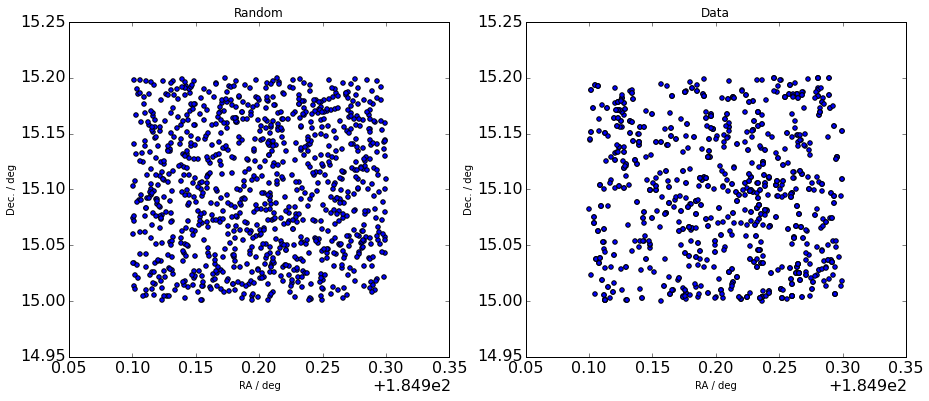

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)
    
random.plot(kind='scatter', x='ra', y='dec', ax=ax[0], title='Random')
ax[0].set_xlabel('RA / deg')
ax[0].set_ylabel('Dec. / deg')

data.plot(kind='scatter', x='ra', y='dec', ax=ax[1], title='Data')
ax[1].set_xlabel('RA / deg')
ax[1].set_ylabel('Dec. / deg')

## Estimating $\xi(\theta)$

In [35]:
import treecorr

random_cat = treecorr.Catalog(ra=random['ra'], dec=random['dec'], ra_units='deg', dec_units='deg')
data_cat = treecorr.Catalog(ra=data['ra'], dec=data['dec'], ra_units='deg', dec_units='deg')

# Set up some correlation function estimator objects:

sep_units='arcmin'
min_sep=0.5
max_sep=10.0
N = 7
bin_size = np.log10(1.0*max_sep/min_sep)/(1.0*N)

dd = treecorr.NNCorrelation(bin_size=bin_size, min_sep=min_sep, max_sep=max_sep, sep_units=sep_units, bin_slop=0.05/bin_size)
rr = treecorr.NNCorrelation(bin_size=bin_size, min_sep=min_sep, max_sep=max_sep, sep_units=sep_units, bin_slop=0.05/bin_size)

# Process the data:
dd.process(data_cat)
rr.process(random_cat)

# Combine into a correlation function and its variance:
xi, varxi = dd.calculateXi(rr)

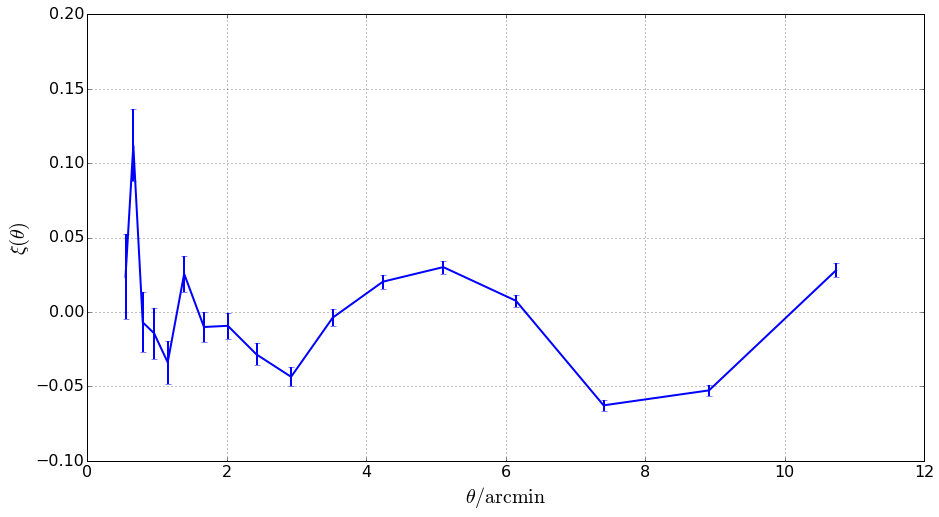

In [36]:
plt.figure(figsize=(15,8))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.errorbar(np.exp(dd.logr),xi,np.sqrt(varxi),c='blue',linewidth=2)
# plt.xscale('log')
plt.xlabel('$\\theta / {\\rm arcmin}$',fontsize=20)
plt.ylabel('$\\xi(\\theta)$',fontsize=20)
plt.ylim([-0.1,0.2])
plt.grid(True)

### Q: Are galaxies uniformly randomly distributed?

Discuss the clustering signal (or lack thereof) in the above plot with your neighbor. What would you want to do better, in a second pass at this?